In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

## Boosting

### Adaboost

adaboost AUC: 0.9375
[0.   0.   0.02 0.   0.   0.07 0.   0.   0.29 0.62 0.   0.   0.  ]


<BarContainer object of 13 artists>

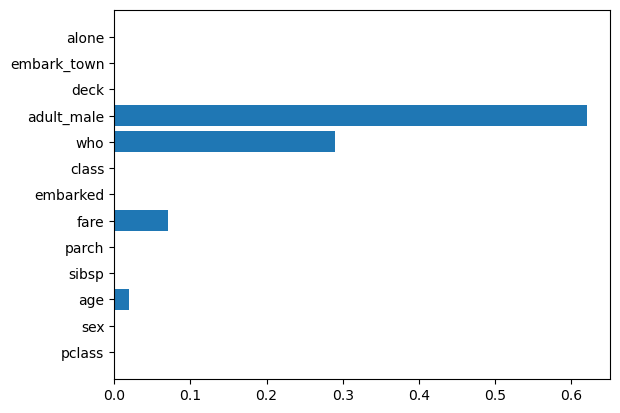

In [2]:
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)

# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']

# ラベルエンコーディング
oe = OrdinalEncoder()
oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred_ada = ada.predict_proba(X_test)
print(f"adaboost AUC: {roc_auc_score(y_test, y_pred_ada[:, 1])}")

# 特徴量重要度
print(ada.feature_importances_)
plt.barh(X.columns, ada.feature_importances_)

### gradient boosting 回帰

### スクラッチで実装

In [3]:
class MyGradientBoostingRegressor:
        
    # 引数はsklearnに合わせる
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = [] # 弱学習器を格納する
    
    def fit(self, X, y):
        # 平均が最も損失を小さくする
        self.F0 = y.mean()
        Fb = self.F0
        
        for _ in range(self.n_estimators):
            # 残差を計算
            r = y - Fb
            # 弱学習器学習
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r) # 正解データは残差rであることに注意
            weight = estimator.predict(X)
            # shrinkage(学習率)をかけて足し合わせていく
            # この時weightはNumPyArrayなので，Fbもイテレーション後はNumPyArrayになることに注意
            Fb += self.learning_rate * weight
            self.estimators.append(estimator)
        
    def predict(self, X):
        Fb = self.F0
        
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)
        
        return Fb

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

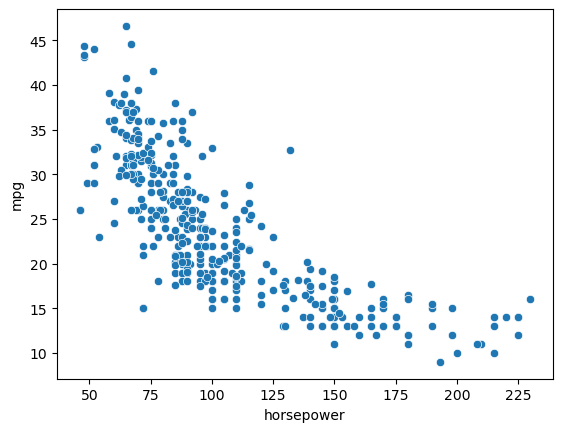

In [4]:
# データ準備
df = sns.load_dataset('mpg')
df.dropna(inplace=True)
X = df['horsepower'].values.reshape(-1, 1)
y = df['mpg'].values
# データの散布図描画
sns.scatterplot(x=df['horsepower'], y=df['mpg'])

In [5]:
my_gbr = MyGradientBoostingRegressor()
my_gbr.fit(X, y)
my_gbr.predict(X)[:10]

array([17.95434839, 15.74535562, 15.74535562, 15.74535562, 16.96376992,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74535562])

###　sklearnのGradientBoostingRegressorを使う

In [6]:
lr = 0.03
gbr = GradientBoostingRegressor(max_depth=1, learning_rate=lr, random_state=0).fit(X, y)
# MyGradientBoostingRegressorの結果と同じであることを確認
gbr.predict(X)[:10]

array([17.95434839, 15.74535562, 15.74535562, 15.74535562, 16.96376992,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74535562])

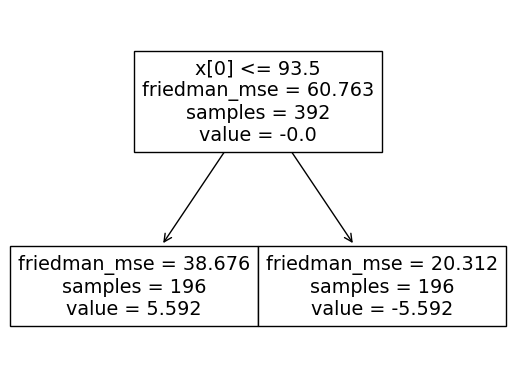

In [7]:
# 弱学習器の木構描画
model = gbr.estimators_[0][0]
_ = plot_tree(model)

In [8]:
# 予測結果が弱学習器の組み合わせになっていることを確認する
results = []
# 一つのデータを選択し，そのデータを使って弱学習器の予測値を得て，最終的な予測値を計算し，.predictの結果と一致するか確認する
idx = 0
for t in gbr.estimators_:
    result = t[0].predict([X[idx]])
    results.append(result*lr)

In [9]:
F0 = np.mean(y)
Fb = F0 + np.cumsum(results)
Fb

array([23.27816327, 23.11544082, 22.94214051, 22.83197263, 22.66717637,
       22.56240126, 22.39804993, 22.29831511, 22.16208788, 22.06741995,
       21.91791807, 21.82781582, 21.68550205, 21.48669171, 21.40205747,
       21.21175047, 21.13072954, 20.93845051, 20.8608364 , 20.73833629,
       20.55782906, 20.50937386, 20.40900234, 20.36266681, 20.19342967,
       20.12570603, 19.9635777 , 19.92025031, 19.77227178, 19.72881191,
       19.57859041, 19.53845808, 19.44223474, 19.38388218, 19.24400857,
       19.20663613, 19.07207991, 19.03612626, 18.96133881, 18.8341415 ,
       18.80004406, 18.8386471 , 18.80441851, 18.75583214, 18.79101068,
       18.76000512, 18.65335356, 18.58370409, 18.55427539, 18.58646165,
       18.55812939, 18.58911825, 18.54763487, 18.57735466, 18.55081739,
       18.48743756, 18.46201512, 18.48989963, 18.43780306, 18.41367401,
       18.43872786, 18.41448352, 18.43860796, 18.4045305 , 18.32739886,
       18.30562399, 18.32804948, 18.30707665, 18.25674972, 18.27

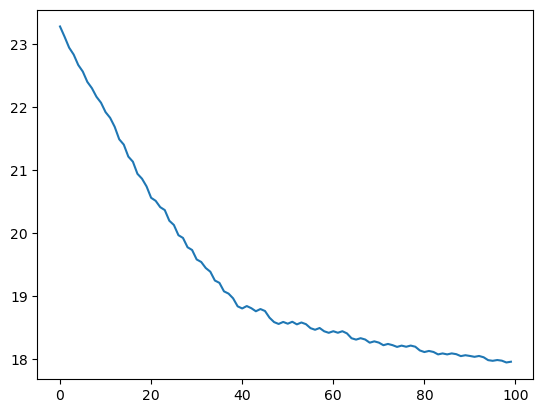

In [10]:
plt.plot(Fb)

### gradient boosting 分類

### スクラッチ実装

#### ヒント

In [11]:
model = DecisionTreeRegressor(max_depth=1, random_state=0).fit(X, y)
# それぞれのデータがどの葉に落ちるかを取得
model.apply(X)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,

In [12]:
# 決定木の葉(およびノード)の値
model.tree_.value

array([[[23.44591837]],

       [[29.0377551 ]],

       [[17.85408163]]])

In [13]:
# 上書き
model.tree_.value[1, 0, 0] = 3

[Text(0.5, 0.75, 'x[0] <= 93.5\nsquared_error = 60.763\nsamples = 392\nvalue = 23.446'),
 Text(0.25, 0.25, 'squared_error = 38.676\nsamples = 196\nvalue = 3.0'),
 Text(0.75, 0.25, 'squared_error = 20.312\nsamples = 196\nvalue = 17.854')]

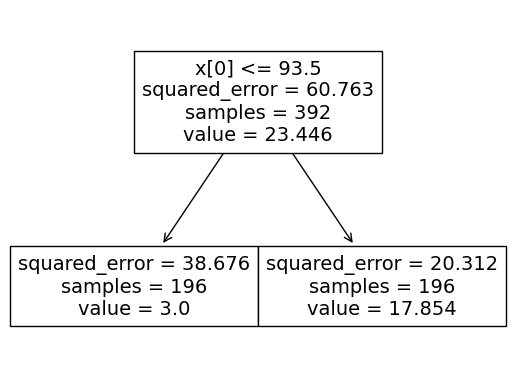

In [14]:
# id=1の値が3に上書きされている
plot_tree(model)

In [15]:
# 予測結果も，id=1は全て3になっている
model.predict(X)[:30]

array([17.85408163, 17.85408163, 17.85408163, 17.85408163, 17.85408163,
       17.85408163, 17.85408163, 17.85408163, 17.85408163, 17.85408163,
       17.85408163, 17.85408163, 17.85408163, 17.85408163, 17.85408163,
       17.85408163, 17.85408163,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        , 17.85408163, 17.85408163,  3.        ,
       17.85408163, 17.85408163, 17.85408163, 17.85408163,  3.        ])

In [16]:
class MyGradientBoostingClassifier:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []
        
    def fit(self, X, y):
        self.F0 = np.log(y.mean()/(1-y.mean()))
        # 特定の葉に対して処理をする必要があるためNumPyArrayにする必要がある
        F0 = np.full(len(y), self.F0)
        Fb = F0
        for _ in range(self.n_estimators):
            # シグモイド関数を使って確率の形にする
            p = 1 / (1 + np.exp(-Fb))
            # 残差計算
            r = y - p
            # 弱学習器学習
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r)
            # それぞれのデータXがどの葉にいくかを取得
            X_leafs = estimator.apply(X)
            # 葉のIDのリスト取得
            leaf_ids = np.unique(X_leafs)
            # それぞれの葉に処理
            for leaf_id in leaf_ids:
                # 弱学習器の出力の値を計算
                fltr = X_leafs == leaf_id
                num = r[fltr].sum() # 分子
                den = (p[fltr]*(1-p[fltr])).sum() # 分母
                estimator_pred_proba = num / den
                # 弱学習器の出力を上書き
                estimator.tree_.value[leaf_id, 0, 0] = estimator_pred_proba
                # 当該データのFbを更新
                Fb[fltr] += self.learning_rate * estimator_pred_proba
            
            self.estimators.append(estimator)
        
    def predict_proba(self, X):
        
        Fb = np.full(X.shape[0], self.F0)
        
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)
        
        return 1 / (1 + np.exp(-Fb))

In [17]:
my_gbc = MyGradientBoostingClassifier()
my_gbc.fit(X_train, y_train) # titanicデータセット
my_gbc.predict_proba(X_test)

array([0.5514342 , 0.4329777 , 0.80125347, 0.80125347, 0.5514342 ,
       0.25797762, 0.5514342 , 0.83715418, 0.88099514, 0.88099514,
       0.5514342 , 0.82137752, 0.82137752, 0.88099514, 0.5514342 ,
       0.5514342 , 0.5514342 , 0.82137752, 0.88099514, 0.40100637,
       0.88099514, 0.78760146, 0.88099514, 0.88099514, 0.80125347,
       0.5514342 , 0.40100637, 0.80125347, 0.4329777 , 0.4329777 ,
       0.4329777 , 0.88099514, 0.88099514, 0.88099514, 0.82137752,
       0.88099514, 0.82137752, 0.88099514, 0.40100637, 0.5514342 ,
       0.4329777 , 0.82137752, 0.5514342 , 0.78760146, 0.40100637,
       0.88099514, 0.88099514, 0.5514342 , 0.5514342 , 0.5514342 ,
       0.5514342 , 0.82137752, 0.5514342 , 0.88099514, 0.88099514])

### sklearnのGradientBoostingClassifierを使う

In [18]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.03, max_depth=1, random_state=0).fit(X_train, y_train)
# MyGradientBoostingClassifierの結果と等しいことを確認
gbc.predict_proba(X_test)[:, 1] == my_gbc.predict_proba(X_test)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [19]:
# 評価
print(f"grad boost AUC: {roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])}")

grad boost AUC: 0.9407051282051282


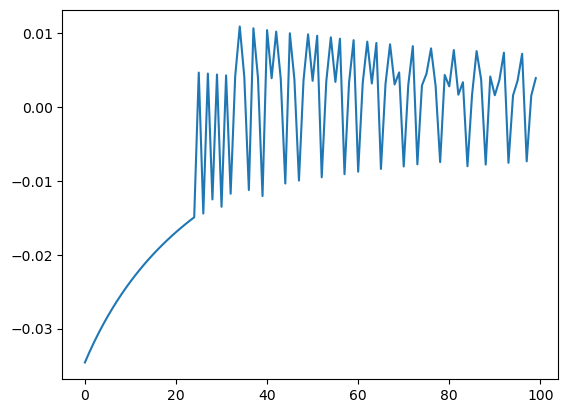

In [20]:
# 弱学習器の予測値からモデル全体の予測値が算出されることを確認する
results = []
for t in gbc.estimators_:
    result = 0.03 * t[0].predict([X_test.iloc[0]]) # idx=0のデータで確認
    results.append(result)
plt.plot(results)

In [21]:
F0 = np.log(y_train.mean()/(1-y_train.mean()))
Fb = F0 + np.cumsum(results)[-1]
predict = 1 / (1 + np.exp(-Fb))
print(predict)

0.551434197251246


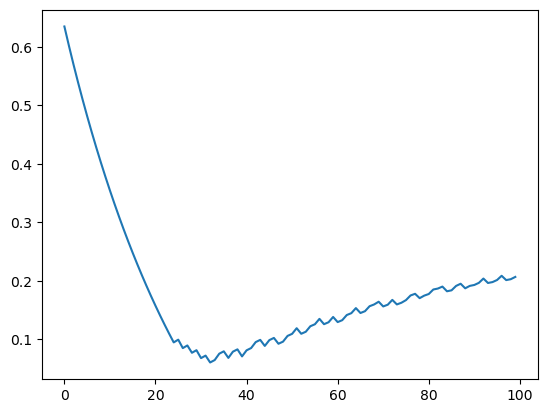

In [22]:
# 弱学習器の数に対しての予測値の推移を描画
plt.plot(np.cumsum(results)+F0)